# Курс "Программирование на языке Python. Уровень 4. Анализ и визуализация данных на языке Python. Библиотеки numpy, pandas, matplotlib"

## Модуль 10. Анализ данных и алгоритмы машинного обучения

1. Математические библиотеки Python и их применение для анализа/предобработки данных - пример полиномиальной регрессии
1. Кластеризация данных и ее роль в отборе признаков и пре-процессинге
2. Анализ продуктовой корзины
2. Применение scipy/sklearn для отбора признаков
5. Полезные ссылки

__Для работы потребуются следующе датасеты:__
- [data/web_traffic.tsv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/web_traffic.tsv)
- [data/store_data.csv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/store_data.csv)
- [data/credit_scoring_train.csv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/credit_scoring_train.csv)

Для некоторых датасетов, которые мы будем сегодня загружать из интернета, может потребоваться порядка 500МБ дискового простанства.


__ВНИМАНИЕ__! Установите библиотеки scipy, sklearn и mlxtend: ```pip install scipy sklearn mlxtend```

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy as sp
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (10.0, 10.0)
%matplotlib inline

### Пример применения полиномиальной регрессии для моделирования данных

Допустим, у нас есть ежечасная статистика веб-траффика по некоторому серверу. Нам нужно определить, когда по времени, с учетом текущей динамики, количество запросов превысит 50000/час, чтобы заранее проапгрейдить оборудование. Для этого мы попытаемся построить кривую с помощью полиномиальной регрессии и экстраполируя ее на будущее, определим крайний срок для апгрейда оборудования.

In [2]:
web_traffic = pd.read_csv('data/web_traffic.tsv', sep='\t', header=None, names=['Hour', 'ReqsPerHour'], index_col='Hour')
web_traffic.head()

,ReqsPerHour
Hour,
1,2272.0
2,NaN
3,1386.0
4,1365.0
5,1488.0


Разберемся с пропущенными данными:

In [3]:
web_traffic.isnull().sum()

ReqsPerHour    8
dtype: int64

In [4]:
web_traffic.dropna(inplace=True)

In [5]:
web_traffic.shape

(735, 1)

Напишем функцию для красивого отображения данных и моделей:

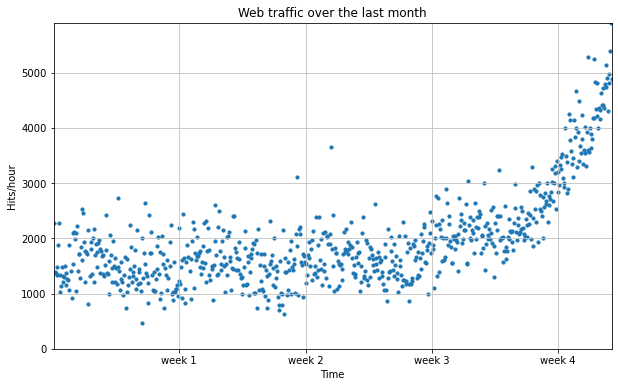

In [6]:
def plot_models(x, y, models, mx=None, ymax=None, xmin=None):
    ''' plot input data '''
    
    colors = ['g', 'k', 'b', 'm', 'r']
    linestyles = ['-', '-.', '--', ':', '-']

    plt.figure(num=None, figsize=(10, 6))
    plt.clf()
    
    plt.scatter(x, y, s=10)
    
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        if mx is None:
            mx = np.linspace(0, x.shape[0], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    plt.grid(True, linestyle='-', color='0.75')
    
plot_models(web_traffic.index, web_traffic.ReqsPerHour, None)

In [7]:
x, y = web_traffic.index, web_traffic.ReqsPerHour

fp1, res1, rank1, sv1, rcond1 = np.polyfit(x, y, 1, full=True)
print("Model parameters of fp1: %s" % fp1)
print("Error of the model of fp1:", res1)
f1 = sp.poly1d(fp1)

Model parameters of fp1: [  2.59619213 989.02487106]
Error of the model of fp1: [3.17389767e+08]


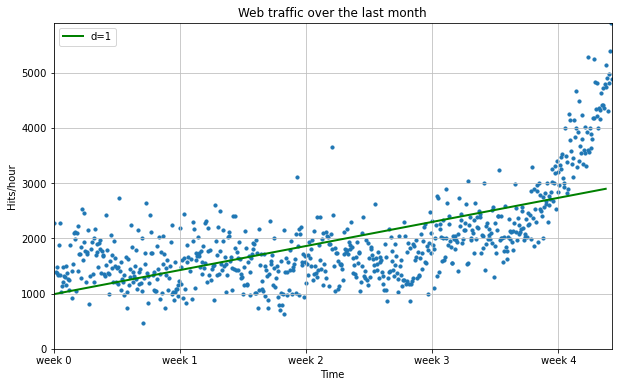

In [8]:
plot_models(x, y, [f1])

Обучим еще несколько моделей с более высокой степенью многочлена:

In [9]:
fp2, res2, rank2, sv2, rcond2 = np.polyfit(x, y, 2, full=True)
print("Model parameters of fp2: %s" % fp2)
print("Error of the model of fp2:", res2)
f2 = sp.poly1d(fp2)
f3 = sp.poly1d(np.polyfit(x, y, 3))
f10 = sp.poly1d(np.polyfit(x, y, 10))
f100 = sp.poly1d(np.polyfit(x, y, 100))

Model parameters of fp2: [ 1.05322215e-02 -5.26545650e+00  1.97476082e+03]
Error of the model of fp2: [1.79983508e+08]


/home/dev/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:658: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/dev/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/dev/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Нарисуем эти модели

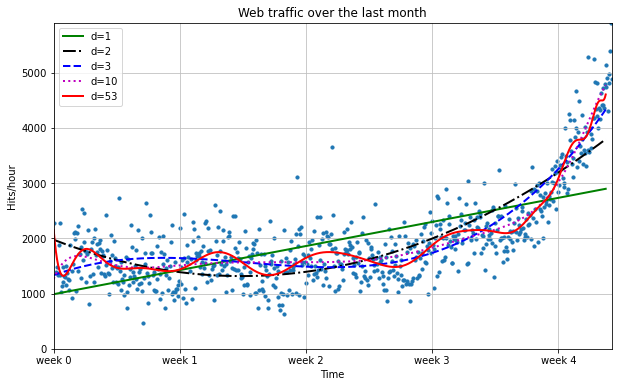

In [10]:
plot_models(x, y, [f1, f2, f3, f10, f100])

Замечаем, что точка перегиба нашего графика находится примерно на середине второй недели. Повторим обучение наших моделей с этим смещением.

In [13]:
# fit and plot a model using the knowledge about inflection point
inflection = int(2.5 * 7 * 24)
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(np.polyfit(xa, ya, 1))
fb = sp.poly1d(np.polyfit(xb, yb, 1))

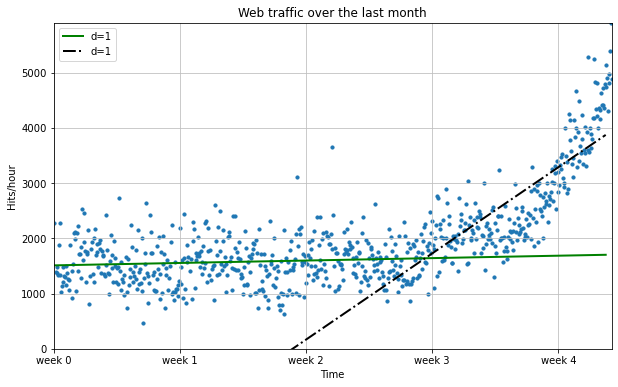

In [14]:
plot_models(x, y, [fa, fb])

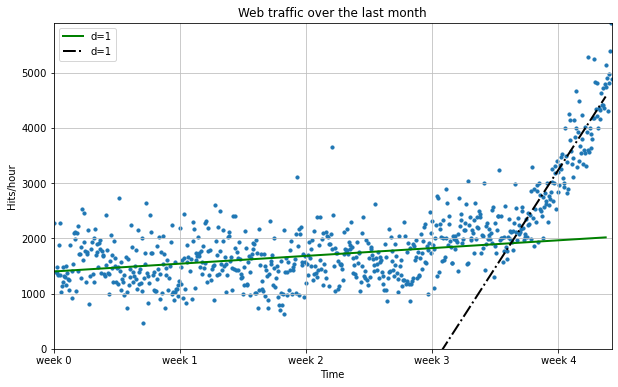

In [12]:
# fit and plot a model using the knowledge about inflection point
inflection = int(3.5 * 7 * 24)
xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(np.polyfit(xa, ya, 1))
fb = sp.poly1d(np.polyfit(xb, yb, 1))
plot_models(x, y, [fa, fb])

Нарисуем существующие модели с экстраполяцией в недалекое будущее (до 6-й недели с начала наблюдений)

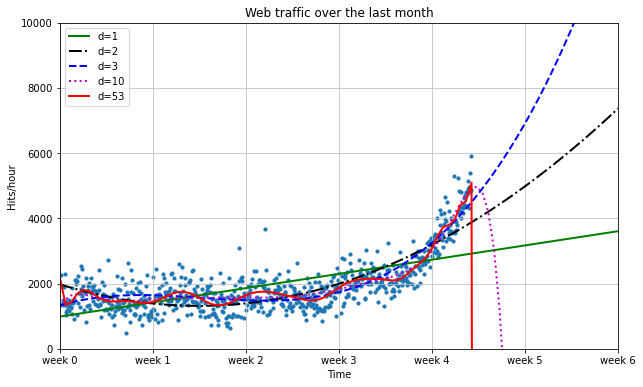

In [15]:
plot_models(
    x, y, [f1, f2, f3, f10, f100],
    mx=np.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

А также создадим несколько моделей, обученных на данных только после второй точки перегиба:

In [16]:
fb1 = fb
fb2 = sp.poly1d(np.polyfit(xb, yb, 2))
fb3 = sp.poly1d(np.polyfit(xb, yb, 3))
fb10 = sp.poly1d(np.polyfit(xb, yb, 10))
fb100 = sp.poly1d(np.polyfit(xb, yb, 100))

/home/dev/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:658: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/dev/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/dev/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Нарисуем их:

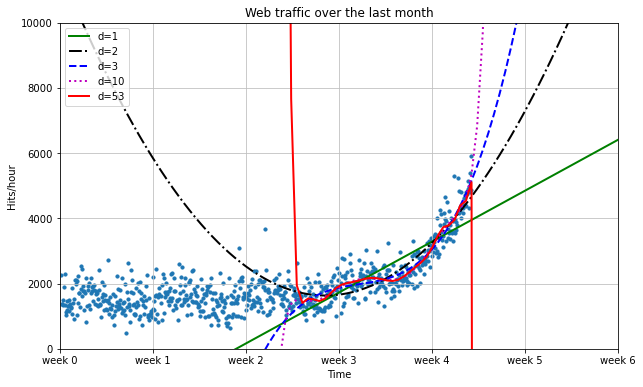

In [17]:
plot_models(
    x, y, [fb1, fb2, fb3, fb10, fb100],
    mx=np.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

#### Оценим точность 

Напишем функцию которая считает среднеквадратичную ошибку для модели и посмотрим, на сколько точны наши первоначальные модели:

In [18]:
def error(f, x, y):
    return np.sum((f(x) - y) ** 2)

print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("Error d={}: {}" .format (f.order, error(f, x, y)))

Errors for the complete data set:
Error d=1: 317389767.339778
Error d=2: 179983507.8781792
Error d=3: 139350144.03172523
Error d=10: 121942326.36370179
Error d=53: 109452403.37663224


...и оценим их же точность, но только после точки перегиба:

In [19]:
print("Errors for only the time after inflection point")
for f in [f1, f2, f3, f10, f100]:
    print("Error d={}: {}" .format(f.order, error(f, xb, yb)))

Errors for only the time after inflection point
Error d=1: 206137514.40856993
Error d=2: 91582377.48013622
Error d=3: 58081162.85898332
Error d=10: 46682493.79698491
Error d=53: 41032817.731485724


...и теперь точность моделей, обученных после точки перегиба:

In [20]:
print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

Errors for only the time after inflection point
Error d=1: 89299409.978686
Error d=2: 56769206.799488
Error d=3: 45648076.920194
Error d=10: 41722977.538908
Error d=53: 40714880.001803


Выберем победительницей модель с полиномом в степени 2. Рассчитаем дату достижения предела в 50000 запросов.

In [21]:
from scipy.optimize import fsolve
reached_max = fsolve(fb2 - 50000, x0=800) / (7 * 24)
print("50,000 hits/hour expected at week %f" % reached_max[0])

50,000 hits/hour expected at week 9.131779


Нарисуем:

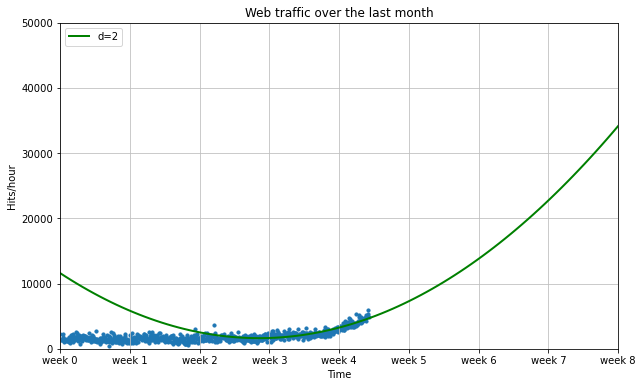

In [22]:
plot_models(
    x, y, [fb2],
    mx=np.linspace(0 * 7 * 24, 8 * 7 * 24, 100),
    ymax=50000, xmin=0 * 7 * 24)

### Пример 2. Кластеризация 

В качестве визуальной оценки данных используется кластеризация.

In [23]:
from sklearn.decomposition import PCA

Метод PCA (метод главных компонент) позволяет уменьшить размерность датасета до 2 (или 3).  Это позволяет визуально оценить "обучаемость" алгоритмов на этих данных. Также метод позволяет выяснить, из чего состоят итоговые компоненты. В основе этого метода лежит сингулярное разложение векторов (SVD). Рассмотрим на примере набора данных "Ирисы":

In [24]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data, iris.target

iris.data.shape

(150, 4)

Meaning of the 2 components:
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


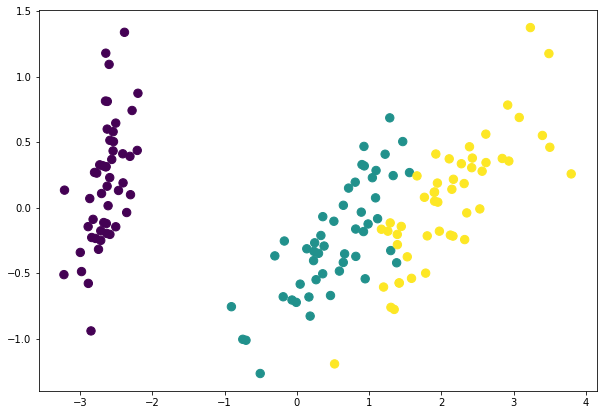

In [25]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))
plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70, cmap='viridis')
plt.show()

Text(0.5, 0, 'z')

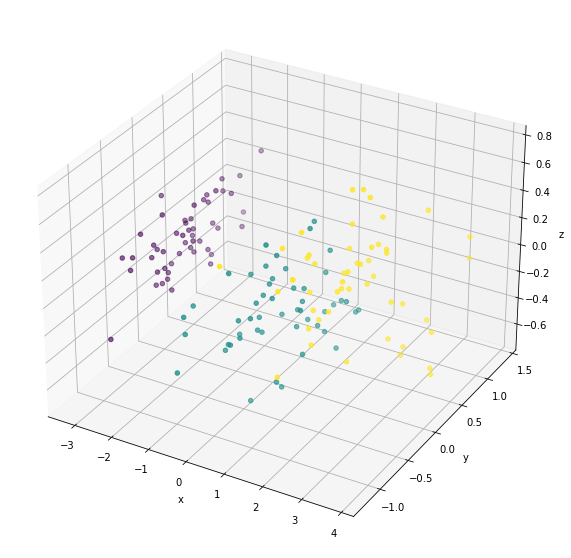

In [26]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter( X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap=plt.cm.get_cmap('viridis'))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Рассмотрим на примере датасета "рукописные цифры". Здесь размерность уменьшена с 64 до 2.

Projecting 64-dimensional data to 2D


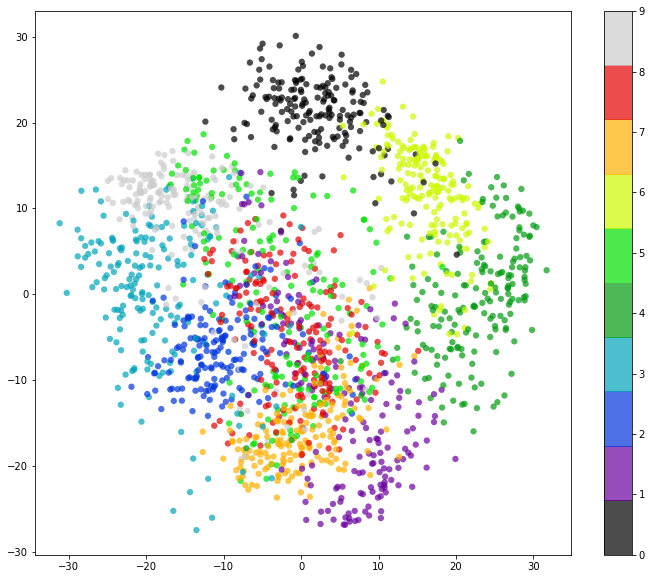

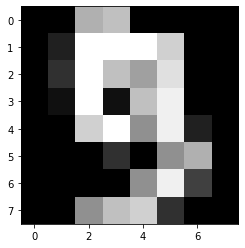

In [31]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()
plt.imshow(X[9].reshape(8, 8), cmap='gray')

No handles with labels found to put in legend.


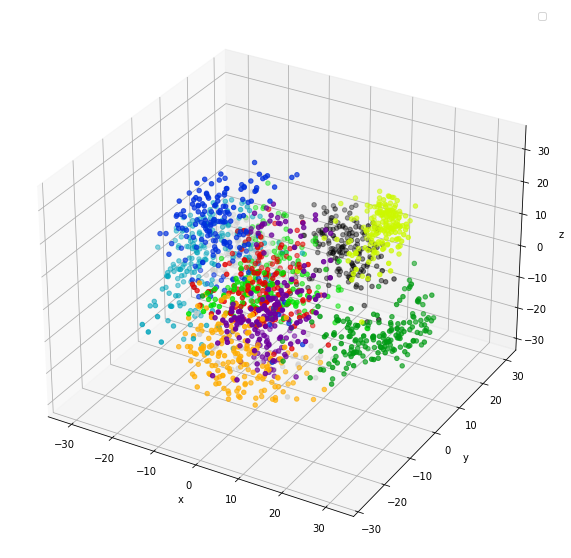

In [32]:
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter( X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap=plt.cm.get_cmap('nipy_spectral'))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

Пример кластеризации по t-SNE.

<AxesSubplot:>

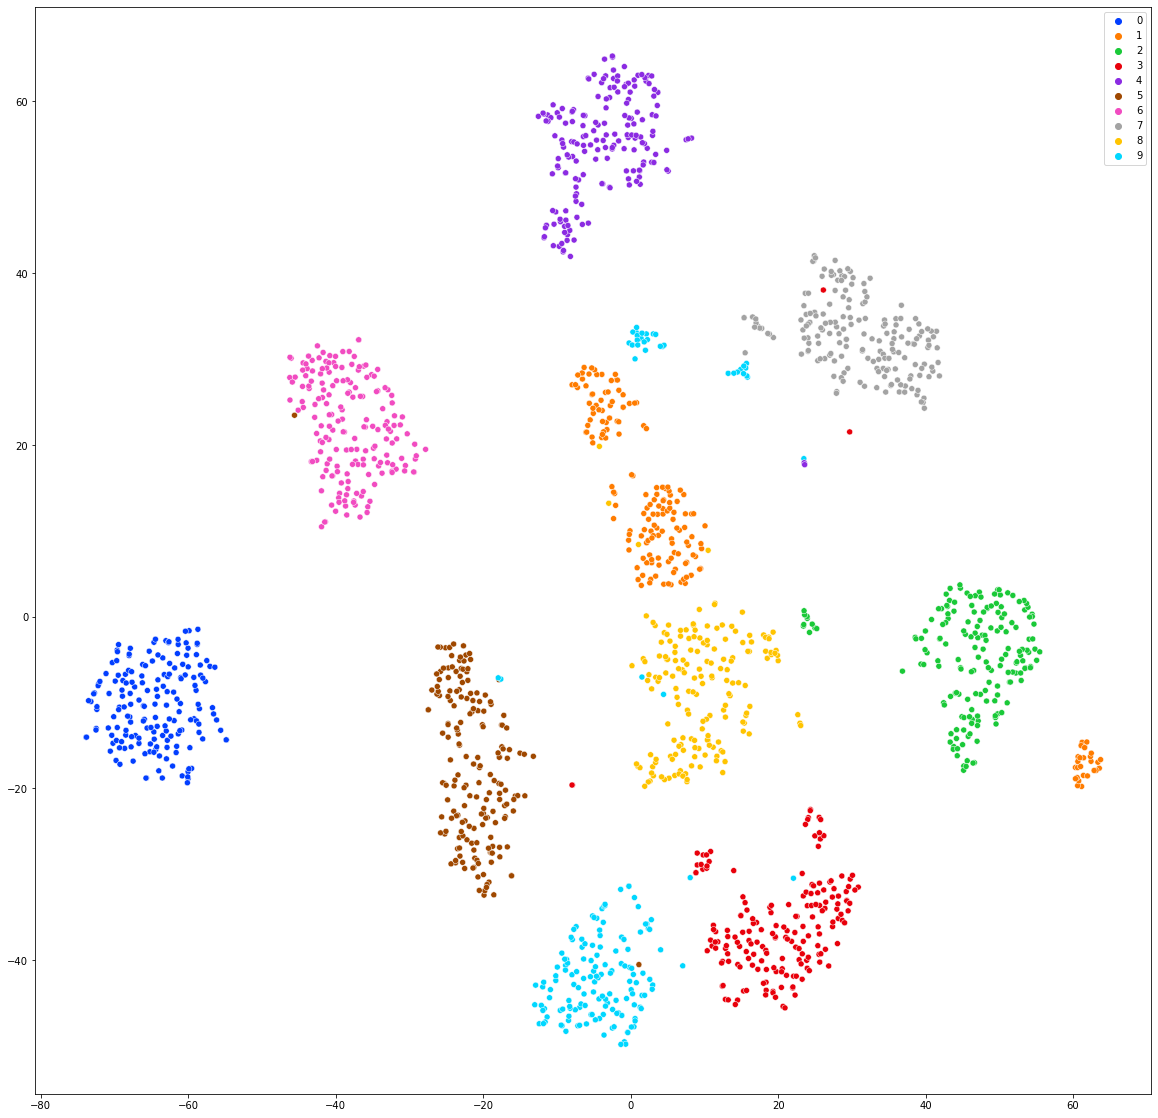

In [33]:
from sklearn.manifold import TSNE

plt.figure(figsize=(20,20))

tsne = TSNE()
X_embedded = tsne.fit_transform(X)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', palette=sns.color_palette("bright", 10))

Text(0.5, 0, 'z')

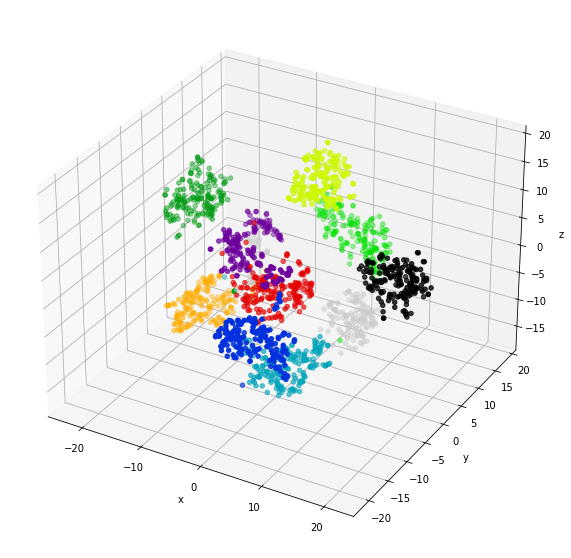

In [34]:
tsne = TSNE(n_components=3)
X_embedded = tsne.fit_transform(X)

ig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter( X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap=plt.cm.get_cmap('nipy_spectral'))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

<AxesSubplot:>

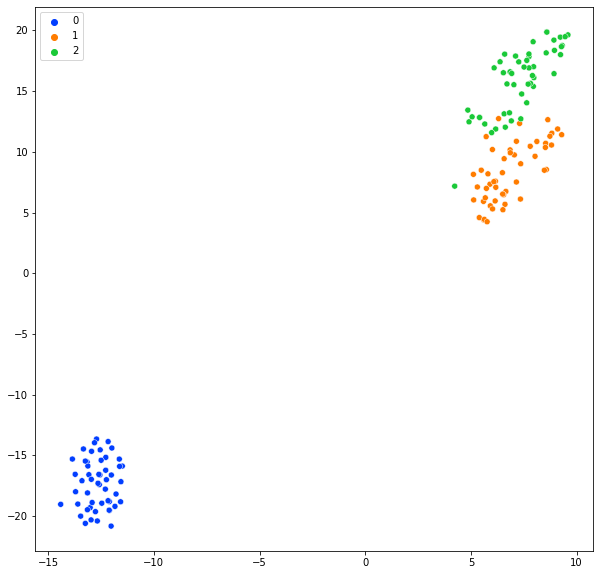

In [36]:
iris = datasets.load_iris()
X, y = iris.data, iris.target


plt.figure(figsize=(10,10))

tsne = TSNE()
X_embedded = tsne.fit_transform(X)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, legend='full', 
                palette=sns.color_palette("bright", 3))

### Пример 3. Анализ покупательской корзины

Это пример "майнинга данных" - поиска зависимостей и закономерностей в массиве данных. "Анализ покупательской корзины" - довольно часто использующийся метод при построении рекомендательных систем. Базовый алгоритм называется ```Apriori```, он был предложен в 1994 году.

Назначение алгоритма - поиск часто встречающихся подмножеств. Он оперирует следующими понятиями:
 - "суппорт" $Support A$ - вероятность покупки товара A, ее можно вычислить как отношение количества покупок A к общему количеству покупок.
 - "конфидент" $Conf  A{\rightarrow}B$  - вычисляется для пары товаров A и B как отношение случаев совместного приобретения этих товаров к покупкам артикула A
 - "подъем" $Lift  A{\rightarrow}B$  - это отношение вероятности приобретения пары товаров A и B к вероятности приобретения товара A. Или попросту говоря, отношение "конфидента" к "суппорту".
 
Давайте "вытащим" из датасета с данными о покупках в некотором французском супермаркете самые популярные товары и их сочетания с помощью алгоритма ```Apriori```.


Прочитаем датасет и посмотрим на его содержимое:

In [37]:
df_store = pd.read_csv('data/store_data.csv', header=None)
print(df_store.shape)
df_store.head()

(7501, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим на список артикулов и их количество:

In [38]:
df_store.stack().unique()

array(['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes',
       'whole weat flour', 'yams', 'cottage cheese', 'energy drink',
       'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad',
       'mineral water', 'salmon', 'antioxydant juice', 'frozen smoothie',
       'spinach', 'olive oil', 'burgers', 'meatballs', 'eggs', 'chutney',
       'turkey', 'milk', 'energy bar', 'whole wheat rice',
       'whole wheat pasta', 'french fries', 'soup', 'light cream',
       'shallot', 'frozen vegetables', 'spaghetti', 'pet food', 'cookies',
       'cooking oil', 'champagne', 'chocolate', 'chicken', 'oil',
       'fresh tuna', 'tomatoes', 'black tea', 'extra dark chocolate',
       'protein bar', 'red wine', 'pasta', 'pepper', 'shampoo', 'rice',
       'sparkling water', 'ham', 'body spray', 'pancakes',
       'grated cheese', 'white wine', 'toothpaste', 'parmesan cheese',
       'fresh bread', 'ground beef', 'escalope', 'herb & pepper',
       'tomato sauce', 'magazines

На базе исходного dataframe создадим dataframe, в котором признаки приобретения того или иного товара станут булевыми dummy признаками. Для этого мы ему сначала сделаем ```stack()```, получим dummy-признаки, а затем сгруппируем по индексу первого уровня со взятием максимума:

In [39]:
df_dummies = pd.get_dummies(df_store.stack()).groupby(level=0).max()
df_dummies.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [44]:
!conda install mlxtend -c mlxtend


UnavailableInvalidChannel: The channel is not accessible or is invalid.
  channel name: mlxtend
  channel url: https://conda.anaconda.org/mlxtend
  error code: 404

You will need to adjust your conda configuration to proceed.
Use `conda config --show channels` to view your configuration's current state,
and use `conda config --show-sources` to view config file locations.




In [45]:
!conda config --show channels

channels:
  - defaults


Запустим алгоритм Apriori и получим список наиболее часто приобретаемых товаров и их сочетаний:

In [46]:
!pip install mlxtend 

     |████████████████████████████████| 1.3 MB 2.6 MB/s eta 0:00:01


In [47]:
from mlxtend.frequent_patterns import apriori

df_apriori = apriori(df_dummies, min_support=0.01, use_colnames=True)
df_apriori

,support,itemsets
0,0.020397,(almonds)
1,0.033329,(avocado)
2,0.010799,(barbecue sauce)
3,0.014265,(black tea)
4,0.011465,(body spray)
...,...,...
252,0.011065,"(ground beef, milk, mineral water)"
253,0.017064,"(spaghetti, ground beef, mineral water)"
254,0.015731,"(spaghetti, milk, mineral water)"
255,0.010265,"(olive oil, spaghetti, mineral water)"


Отсортируем список:

In [48]:
df_apriori.sort_values('support', ascending=False)

,support,itemsets
46,0.238368,(mineral water)
19,0.179709,(eggs)
63,0.174110,(spaghetti)
24,0.170911,(french fries)
13,0.163845,(chocolate)
...,...,...
255,0.010265,"(olive oil, spaghetti, mineral water)"
123,0.010132,"(chocolate, soup)"
246,0.010132,"(ground beef, eggs, mineral water)"
249,0.010132,"(spaghetti, french fries, mineral water)"


Теперь получим список самых популярных сочетаний для 2-х и 3-х товаров в корзине:

In [49]:
df_apriori['item_count'] = df_apriori['itemsets'].apply(len)
df_apriori[ df_apriori.item_count >=2 ].sort_values('support', ascending=False)

,support,itemsets,item_count
224,0.059725,"(spaghetti, mineral water)",2
118,0.052660,"(chocolate, mineral water)",2
144,0.050927,"(eggs, mineral water)",2
209,0.047994,"(milk, mineral water)",2
196,0.040928,"(ground beef, mineral water)",2
...,...,...,...
232,0.010265,"(spaghetti, red wine)",2
249,0.010132,"(spaghetti, french fries, mineral water)",3
246,0.010132,"(ground beef, eggs, mineral water)",3
123,0.010132,"(chocolate, soup)",2


### Пример 4. Отбор признаков средствами машинного обучения

Решается задача кредитного скоринга. 

Признаки клиентов банка:
- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный)
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

In [52]:
df = pd.read_csv('data/credit_scoring_train.csv', index_col='client_id')
df.head()
df

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
client_id,,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0
...,...,...,...,...,...,...,...,...,...,...
74995,0.169463,67.6,5,1,0.0,0,0,20129.654428,0.074689,0
74996,2085.662215,43.2,1,1,0.0,0,0,NaN,1.005390,0
74997,0.118935,23.0,4,0,0.0,2,0,2019.117329,0.384511,0


In [53]:
train_df.shape

(75000, 10)

Как обычно, проверим на NaN:

In [54]:
train_df.isnull().sum()

DIR                          0
Age                          0
NumLoans                     0
NumRealEstateLoans           0
NumDependents             1916
Num30-59Delinquencies        0
Num60-89Delinquencies        0
Income                   14847
BalanceToCreditLimit         0
Delinquent90                 0
dtype: int64

Заменим NaN на медианные значения:

In [59]:
train_df['NumDependents'].fillna(train_df['NumDependents'].median(), inplace=True)
train_df['Income'].fillna(train_df['Income'].median(), inplace=True)

X = train_df.iloc[:,:-1]  # определяющие признаки
y = train_df.iloc[:,-1]    # результирующие признаки

Для отбора признаков воспользуемся модулем SelectKBest c определением корелляции по $chi^2$

In [60]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                   Specs          Score
7                 Income  663458.105886
6  Num60-89Delinquencies   52170.942852
5  Num30-59Delinquencies   46880.212062
0                    DIR   35398.322099
1                    Age    4111.293655
8   BalanceToCreditLimit     768.237735
4          NumDependents     261.983308
2               NumLoans     196.315203
3     NumRealEstateLoans       8.895203


Также можно отобрать признаки, используя саму модель - обычно модель возаращает ранжированный по важности список признаков.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Также бывает полезно посмотреть кореляцию признаков с результирующим, построив heatmap.

In [ ]:
#get correlations of each features in dataset
corrmat = train_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

А теперь - сеанс машинного обучения, с небольшим анализом.

Для начала загрузим пару классификаторов ("дерево решений" и "случайный лес"), а также библиотеку для вычисления метрик точности нашей модели.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score



Создадим обучающую и тестовую выборку:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=20200212,
                                                   stratify = y)

Обучим "дерево решений":

In [ ]:
first_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
first_tree.fit(X_train, y_train)

Посмотрим на точность рассчетов:

In [ ]:
test_pred = first_tree.predict(X_test)
print("Accuracy score: {}, f1: {}".format(accuracy_score(y_test, test_pred),f1_score(y_test, test_pred)))

Теперь возьмем более точный "случайный лес":

In [ ]:
forest = RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1)

forest.fit(X_train,y_train)

Теперь посмотрим, на склько он лучше... или хуже?

In [ ]:
test_pred = forest.predict(X_test)
print("Accuracy score: {}, f1: {}".format(accuracy_score(y_test, test_pred),f1_score(y_test, test_pred)))

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

### Разные примеры

1. Анимация в Jupyter Notebook

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.animation as animation
%matplotlib notebook # !!! ВАЖНО!


def data_gen(t=0):
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.1
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, data_gen, blit=False, interval=10,
                              repeat=False, init_func=init)
plt.show()

  2. Применение фильтров к изображениям:

In [ ]:
import matplotlib.image as mpimg
lena = mpimg.imread('data/lena.jpg')
plt.imshow(lena)

Документация: https://docs.scipy.org/doc/scipy/reference/ndimage.html

In [ ]:
from scipy.ndimage import filters
lena_blur = filters.gaussian_filter(lena, 5)
%matplotlib inline
plt.imshow(lena_blur)

3. Работа со звуком и преобразование Фурье

См. https://notebooks.ai/a-n-rose/visualizing-the-fourier-transfrom-in-python-4f954bbf

4. Нейронные сети

В рамках данной демонстрации мы, конечно, не будем углубляться во все тонкости обучения, настройки и использования нейросетей, это тема для отдельного курса. Ниже - просто пример использования сети imagenet в задаче распознавания образов: 

In [ ]:
import keras
keras.__version__

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

model = VGG16(weights='imagenet')

In [ ]:
# Загрузим изображение
img_path = 'data/creative_commons_elephant.jpg'

img_full = image.load_img(img_path)
plt.imshow(img_full)

In [ ]:
# выполним необходимый пре-процессинг изображения и вызовем функцию predict()

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [ ]:
# узнать об архитектуре и свойствах модели можно с помощью функции summary()

model.summary()

### ПОЛЕЗНОЕ

1. Зарегистрируйтесь на https://kaggle.com
2. Читайте специальный раздел на Medium [TowardsDataScience.com](https://towardsdatascience.com)
3. Оттуда - пара статей про векторизацию кода: [1](https://medium.com/@mikeliao/numpy-vectorization-d4adea4fc2a) и [2](https://towardsdatascience.com/python-vectorization-5b882eeef658)
5. Рекомендую книгу о векторизации ["From Python to Numpy"](https://www.labri.fr/perso/nrougier/from-python-to-numpy/)
4. Еще можно бесплатно пройти курсы Стэнфорского Университета: "Машинное обучение", [CS229](http://cs229.stanford.edu/), "Глубокое обучение", [CS231n](http://cs231n.stanford.edu/).


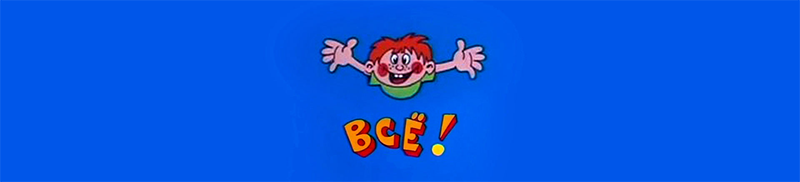